# Continuous Control

---

This Notebook implements the solution for the 2. project in the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='Reacher_20_Windows_x86_64/Reacher.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Train the agent using DDPG

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [5]:
from collections import deque
import torch
import matplotlib.pyplot as plt
%matplotlib inline



In [6]:
def ddpg(agent, env_info, n_episodes=1000, max_t=1000, print_every=100, run=0):
    scores_deque = deque(maxlen=print_every)
    
    score = []
    solved = False
    for i_episode in range(1, n_episodes+1):
        #state = env.reset()
        
        scores = np.zeros(num_agents)
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations              # get the current state
        agent.reset()
        for t in range(max_t):
            actions = agent.act(state)                    # select an action
            env_info = env.step(actions)[brain_name]      # send the action to the environment
            next_state = env_info.vector_observations     # get the next state
            reward = env_info.rewards                     # get the reward
            done = env_info.local_done                    # see if episode has finished
            agent.step(state, actions, reward, next_state, done)
            state = next_state
            scores += reward
            
            
            if np.any(done):
                break 
        scores_deque.append(np.mean(scores))
        score.append(np.mean(scores))
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_'+str(run)+'.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_'+str(run)+'.pth')
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if (np.mean(scores_deque)>=30.0) & (not solved):
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            solved = True
            
    return score

### 3.1 Learning Algorithm

The learning algorithm used to solve this learning is the DDPG algorithm described in the paper [Continuous control with deep reinforcement learning](https://arxiv.org/abs/1509.02971)

This is a modification of the DQN algorithm that is extended to work for continuous output space. 
The DQN network from the previous lesson took an input, and predicted an action. however this agent needs to learn the appropriate force to apply to each joint of the robot arm. The force is a continuous variable from 0-1.

DDPG uses 2 networks, one to predict the action, and one to evaluate the action, and provide the contentious output.  

**Hyperparameters are taken from the paper:**
 
We used Adam (Kingma & Ba, 2014) for learning the neural network parameters with a learningrate of 10e−4 and 10e−3 for the actor and critic respectively.  For Q we included L2 weight decay of 1e−2 and used a discount factor of γ = 0.99.
For the soft target updates we used τ = 0.001.
We used an Ornstein-Uhlenbeck process (Uhlenbeck& Ornstein, 1930) with θ = 0.15 and σ = 0.2.
We used a replay buffer size of 1e6  

**Network:**  
Actor(  
  (fc1): Linear(in_features=33, out_features=400, bias=True)  
  (fc2): Linear(in_features=400, out_features=300, bias=True)  
  (fc3): Linear(in_features=300, out_features=4, bias=True)  
)  
Actor has input matching the Environment, and output matching the output space

Critic(  
  (fcs1): Linear(in_features=33, out_features=400, bias=True)  
  (fc2): Linear(in_features=404, out_features=300, bias=True)  
  (fc3): Linear(in_features=300, out_features=1, bias=True)  
)  
Critic has input matching the Environment, and one output giving the size of the continuous action.



In [17]:
# Import Agent and model
from ddpg_agent import Agent

# Hyperparameters for the agent parameters from example

buffer_size = int(1e6) # replay buffer size
batch_size = 64        # minibatch size
gamma = 0.99           # discount factor
tau = 1e-3             # for soft update of target parameters
lr_actor = 1e-4        # learning rate of the actor
lr_critic = 1e-3       # learning rate of the critic
weight_decay = 1e-2    # L2 weight decay


agent = Agent(state_size=33, 
              action_size=4,
              num_agents = 20,
              random_seed=2,
              buffer_size = buffer_size,
              batch_size = batch_size,
              gamma = gamma,
              tau = tau,
              lr_actor = lr_actor,
              lr_critic = lr_critic,
              weight_decay = weight_decay
             )

print(agent.actor_local)
print(agent.critic_local)

Actor(
  (fc1): Linear(in_features=33, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=4, bias=True)
)
Critic(
  (fcs1): Linear(in_features=33, out_features=400, bias=True)
  (fc2): Linear(in_features=404, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=1, bias=True)
)


Episode 100	Average Score: 0.80
Episode 200	Average Score: 1.37
Episode 300	Average Score: 1.17
Episode 400	Average Score: 0.98
Episode 500	Average Score: 0.73
Episode 600	Average Score: 0.96
Episode 700	Average Score: 1.25
Episode 800	Average Score: 0.92
Episode 900	Average Score: 0.71
Episode 1000	Average Score: 0.90


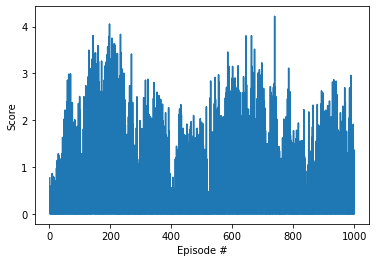

In [18]:
scores = ddpg(agent, env_info, run=0)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Below we try the hyperparameters suggested by the course example implementation

In [9]:
# Import Agent and model
from ddpg_agent import Agent

# Hyperparameters for the agent parameters from example

buffer_size = int(1e5) # replay buffer size
batch_size = 128       # minibatch size
gamma = 0.99           # discount factor
tau = 1e-3             # for soft update of target parameters
lr_actor = 1e-4        # learning rate of the actor
lr_critic = 1e-3       # learning rate of the critic
weight_decay = 0       # L2 weight decay


agent = Agent(state_size=33, 
              action_size=4,
              num_agents = 20,
              random_seed=2,
              buffer_size = buffer_size,
              batch_size = batch_size,
              gamma = gamma,
              tau = tau,
              lr_actor = lr_actor,
              lr_critic = lr_critic,
              weight_decay = weight_decay
             )


Episode 100	Average Score: 16.41
Episode 142	Average Score: 30.28
Environment solved in 42 episodes!	Average Score: 30.28
Episode 200	Average Score: 36.95
Episode 300	Average Score: 36.86
Episode 400	Average Score: 36.37
Episode 500	Average Score: 35.34
Episode 600	Average Score: 34.82
Episode 700	Average Score: 35.42
Episode 800	Average Score: 34.28
Episode 900	Average Score: 34.73
Episode 1000	Average Score: 33.87


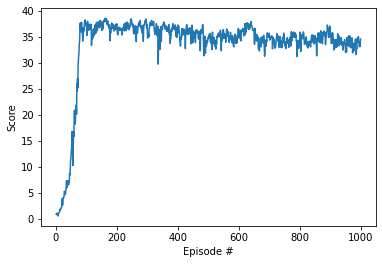

In [10]:
scores = ddpg(agent, env_info, run=1)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [14]:
agent.actor_local.load_state_dict(torch.load('checkpoint_actor_1.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic_1.pth'))

max_t = 1000


for i in range(3):
    scores = np.zeros(num_agents)
    env_info = env.reset(train_mode=False)[brain_name] # reset the environment
    state = env_info.vector_observations               # get the current state
    agent.reset()
    for t in range(max_t):
        actions = agent.act(state,False)           # select an action
        env_info = env.step(actions)[brain_name]    # send the action to the environment
        next_state = env_info.vector_observations   # get the next state
        reward = env_info.rewards                   # get the reward
        done = env_info.local_done                  # see if episode has finished
        agent.step(state, actions, reward, next_state, done)
        state = next_state
        scores += reward


        if np.any(done):
            break 
    print("Score: {}".format(np.mean(scores)))

Score: 39.20199912376702
Score: 38.609499137010424
Score: 38.54399913847446


### 4 Conclsion

Learning were done using hyper parameters from the [Continuous control with deep reinforcement learning](https://arxiv.org/abs/1509.02971) paper, and using the hyper parameters from the course example code.

The Paper uses a larger buffer, and smaller batches, and uses weight decay. using this hyper parameters the agent were unable to learn. using the parameters from the course example the network trains well and solves the problem un 42 rounds.

The environment is considered solved, when the average (over 100 episodes) of those average scores is at least +30. In the case of the plot above, the environment was solved at episode 42, since the average of the average scores from episodes 42 to 142 (inclusive) was greater than +30.

### 5 Future Work

- Try out other algorithms like 
 - Trust Region Policy Optimization (TRPO)
 - Truncated Natural Policy Gradient (TNPG) 
 - Proximal Policy Optimization (PPO)
 - Distributed Distributional Deterministic Policy Gradients (D4PG) 
- Finetune hyperparameters further